<a href="https://www.kaggle.com/code/sharanharsoor/fine-tune-bert-for-queation-pair-classification?scriptVersionId=123012650" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

this notebook how to fine-tune BERT-based models for the sentence-pair classification task. This TensorFlow implementation leverages the Hugging face transformers and datasets libraries to download pre-trained models, enable quick research experiments and evaluation metrics.

This task is part of the semantic textual similarity/duplicate problem. You have two pair of questions and you want to model the textual interaction between them.

The dataset used in this notebook is Quora Question Pair (QQP) which is part of the GLUE benchmark : you have two sentences(questions) and you want to predict if one sentence is the paraphrase of the other one. The evaluation metrics are F1 and accuracy.

The main features of this tutorial are :

End-to-end ML implementation (training, validation, prediction, evaluation)
Usage of your own datasets
Facilitation of quick experiments with other BERT-based models (BERT, ALBERT, ...)
Comparison of finetuned model with model w/o finetuning.

In [1]:
import os
import matplotlib.pyplot as plt
import copy

import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
! cp /kaggle/input/quora-question-pairs/train.csv.zip .

In [3]:
train = pd.read_csv("./train.csv.zip")
print(train.shape)
train.sample(5)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
37276,37276,67850,67851,How does lingua franca work?,"In ""German was the lingua franca,"" should ""lin...",0
331962,331962,289702,458921,What programming language is the most used to ...,How are PlayStation games created and which la...,0
36487,36487,66523,66524,Who is the biggest traitor in the history of C...,Who is the biggest traitor in the history of S...,0
127719,127719,57970,205566,What's the difference between a TF card and a ...,Can I used a Micro SD card instead of a TF card?,0
388127,388127,356864,520491,My age is 14. Can I go to the gym?,What's the best age of join gym?,0


In [4]:
print(train.isnull().sum().sum())
train.info()

3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
train = train[~train.isna().any(axis=1)]
print(train.isnull().sum().sum())
train.info()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [6]:
train.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
train.sample(5)

,question1,question2,is_duplicate
333896,What is it like to be diagnosed with ocd?,What does it feel like to have OCD?,1
343591,Why was Cyrus Mistry removed as the Chairman o...,What is the reason behind replacing cyrius mis...,1
173660,How do I fix my garage door opener?,How can I reset my garage door opener?,0
182306,What type of benefits do you have if you join ...,What type of benefits do you have if you join ...,0
376505,"If you could be invisible at will, what would ...",What would you do if you have invisible power ...,1


In [7]:
test = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv.zip")
print(test.shape)
test.tail(5)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(3563475, 3)


,test_id,question1,question2
3563470,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
3563471,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
3563472,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
3563473,2345794,What were the best and worst things about publ...,What are the best and worst things examination...
3563474,2345795,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?


In [8]:
sub = pd.read_csv("/kaggle/input/quora-question-pairs/sample_submission.csv.zip")
print(sub.shape)
sub.tail(5)

(2345796, 2)


,test_id,is_duplicate
2345791,2345791,1
2345792,2345792,1
2345793,2345793,1
2345794,2345794,1
2345795,2345795,1


# Reading data as Huggingface dataset object

In [9]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=1, shuffle=False)
train_data.to_csv('train_clean.csv',index=False)
val_data.to_csv('val_clean.csv',index=False)

In [10]:
dataset = load_dataset('csv', data_files={'train': './train_clean.csv',\
                                          'valid':'./val_clean.csv'},)
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2594efa7aaf2398b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 323429
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 80858
    })
})

In [11]:
model_checkpoint = "bert-base-cased"
batch_size = 32

In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Sample Tokenization

In [13]:
tokenizer(train.question1[0], train.question2[0], 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=100,  
                                      return_tensors='tf',return_token_type_ids = True)  # Return torch.Tensor objects

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106,
        17557,  1107,  2934,  2319,  1107,  1107,  7168,   136,   102,
         1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106, 17557,
         1107,  2934,  2319,   136,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Tokenizer for Model Training

In [14]:
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length = 75)

In [15]:
pre_tokenizer_columns = set(dataset["train"].features)

In [16]:
pre_tokenizer_columns

{'is_duplicate', 'question1', 'question2'}

In [17]:
encoded_dataset = dataset.map(preprocess_function, batched=True, )

  0%|          | 0/324 [00:00<?, ?ba/s]

  0%|          | 0/81 [00:00<?, ?ba/s]

In [18]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 323429
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 80858
    })
})

In [19]:
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['attention_mask', 'input_ids', 'token_type_ids']


# Data padding and batching

In [20]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [21]:
# sample train batch
z = next(iter(tf_train_dataset))

In [22]:
# sample decoded string
tokenizer.decode(z[0]['input_ids'][0])

'[CLS] When do we use na, da and do in Portuguese? [SEP] When do you use do, da and de in Portuguese? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [23]:
# Number of classes in the classification task
num_labels = train.is_duplicate.nunique()
num_labels

2

# Loading the model checkpoint


In [24]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Hyperparameters

In [25]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

# Closer look at the learning rate scheduler

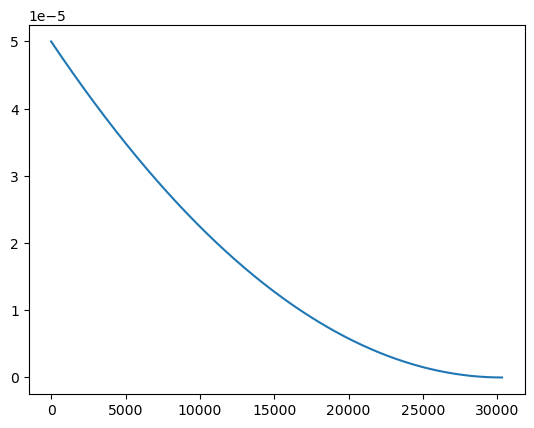

In [26]:
lr_schedule = []
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr_schedule.append(lr_scheduler.initial_learning_rate * decay)

plt.plot(lr_schedule)

In [27]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [28]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

Epoch 1/3
10107/10107 [==============================] - 3040s 296ms/step - loss: 0.3102 - accuracy: 0.8619 - val_loss: 0.2439 - val_accuracy: 0.8953
Epoch 2/3
10107/10107 [==============================] - 2970s 294ms/step - loss: 0.1720 - accuracy: 0.9313 - val_loss: 0.2441 - val_accuracy: 0.9050
Epoch 3/3
10107/10107 [==============================] - 2971s 294ms/step - loss: 0.0929 - accuracy: 0.9659 - val_loss: 0.2881 - val_accuracy: 0.9061


In [29]:
model.save_pretrained("./saved_model_epoch2/")

In [30]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained('./saved_model_epoch2/',num_labels = num_labels)

Some layers from the model checkpoint at ./saved_model_epoch2/ were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./saved_model_epoch2/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [31]:
def check_similarity(question1, question2, debug = 0):
  tokenizer_output = tokenizer(question1, question2, truncation=True, return_token_type_ids=True, max_length = 75, return_tensors = 'tf')
  logits = trained_model(**tokenizer_output)["logits"]
  predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
  if predicted_class_id == 1:
    if(debug):
        print("Both questions mean the same")
    return 1
  else:
    if(debug):
        print("Both the questions are different.")
    return 0


In [32]:
check_similarity("Why are people so obsessed with cricket?", "Why are people so obsessed with football?", 1)

Both the questions are different.


0

In [33]:
check_similarity("Why are people so obsessed with cricket?", "Why do people like cricket?", 1)

Both questions mean the same


1

In [34]:
fianl_pred = pd.DataFrame()

In [35]:
# checking the 100 entries similarity 
i = 0
for index, row in test.iterrows():
    i+=1
    pred = check_similarity(row['question1'], row['question1'])
    fianl_pred = fianl_pred.append({'test_id':row['test_id'], 'is_duplicate':pred}, ignore_index=True)
    if(i == 1000):
        break


In [36]:
print(len(fianl_pred))
fianl_pred.sample(10)

1000


,test_id,is_duplicate
282,282.0,1.0
149,149.0,1.0
510,510.0,1.0
937,937.0,1.0
386,386.0,1.0
507,507.0,1.0
178,178.0,1.0
643,643.0,1.0
925,925.0,1.0
622,622.0,1.0


In [37]:
fianl_pred.is_duplicate.value_counts()

1.0    996
0.0      4
Name: is_duplicate, dtype: int64

# Huggingface Transformers Introduction

Since we have used Huggingface Transformers for implementation, in below we will see some more basics for the same.

In [38]:
import pprint
pp = pprint.PrettyPrinter(depth=4, width=120, compact=True)

In [39]:
!pip install datasets transformers[sentencepiece] tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires di

## Using the pipelines

In [40]:
from transformers import pipeline

generator = pipeline("text-generation")
generator("In the galaxy far far")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1187: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  "You have modified the pretrained model configuration to control generation. This is a"
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1278: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 50 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


[{'generated_text': 'In the galaxy far far back, where the ancient galaxy was, the galactic core, which contained some of the most advanced and technologically advanced galaxies of our own solar system, was one of those places. And at the core of such the galaxy, known'}]

## Specifying a custom model in the pipeline

In [41]:
from transformers import pipeline

generator = pipeline("text-generation", model="distilgpt2")
generator(
    "In the galaxy far far",
    max_length=30,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'In the galaxy far far away—and now, with the release of the latest version of the popular open-source OpenOffice for iOS, and the'},
 {'generated_text': 'In the galaxy far far out of reach, and you\u202a have to deal with that. You know, with one person you know – you know'}]

## Available Pipelines


- AudioClassificationPipeline
- AutomaticSpeechRecognitionPipeline
- ConversationalPipeline
- FeatureExtractionPipeline
- FillMaskPipeline
- ImageClassificationPipeline
- ImageSegmentationPipeline
- ObjectDetectionPipeline
- QuestionAnsweringPipeline
- SummarizationPipeline
- TableQuestionAnsweringPipeline
- TextClassificationPipeline
- TextGenerationPipeline
- Text2TextGenerationPipeline
- TokenClassificationPipeline
- TranslationPipeline
- VisualQuestionAnsweringPipeline
- ZeroShotClassificationPipeline
- ZeroShotImageClassificationPipeline

## Looking inside the pipeline with Tensorflow API

In [42]:
input_sentences = [
        "I don't like this movie",
        "Upgrad is helping me learn new and wonderful things.",
        
    ]
classifier = pipeline("sentiment-analysis")
classifier(
    input_sentences
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9839025139808655},
 {'label': 'POSITIVE', 'score': 0.9998325109481812}]

## Tokenizing the input sentences

In [43]:
model = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model)

In [44]:
inputs = tokenizer(input_sentences, padding=True, truncation=True, max_length = 12, return_tensors="tf",)
pp.pprint(inputs)

{'attention_mask': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>,
 'input_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[  101,  1045,  2123,  1005,  1056,  2066,  2023,  3185,   102,
            0,     0,     0],
       [  101,  2039, 16307,  2003,  5094,  2033,  4553,  2047,  1998,
         6919,  2477,   102]], dtype=int32)>}


## Classifying the input sentences into positive and negative sentiments

In [45]:
from transformers import TFAutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(model)
outputs = model(inputs)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_95']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
pp.pprint(outputs.logits.shape)

TensorShape([2, 2])


In [47]:
pp.pprint(outputs.logits)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 2.2426069, -1.870255 ],
       [-4.1284223,  4.4328403]], dtype=float32)>


In [48]:
predictions = tf.math.softmax(outputs.logits, axis=-1)
pp.pprint(predictions)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[9.8390251e-01, 1.6097520e-02],
       [1.9134098e-04, 9.9980873e-01]], dtype=float32)>


## Exploring the Tokenizer

In [49]:
tokenized_text = "Learning NLP is so much rewarding".split()
pp.pprint(tokenized_text)

['Learning', 'NLP', 'is', 'so', 'much', 'rewarding']


In [50]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [51]:
tokenizer("Learning NLP is so much rewarding")

{'input_ids': [101, 9681, 21239, 2101, 1110, 1177, 1277, 10703, 1158, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Breaking the tokenizer functions down

In [52]:
tokens = tokenizer.tokenize("Learning NLP is so much rewarding", )
pp.pprint(tokens)

['Learning', 'NL', '##P', 'is', 'so', 'much', 'reward', '##ing']


In [53]:
ids = tokenizer.convert_tokens_to_ids(tokens)
pp.pprint(ids)

[9681, 21239, 2101, 1110, 1177, 1277, 10703, 1158]


## more info

In [54]:
tokens = tokenizer.tokenize("Learning NLP is so much rewarding", add_special_tokens = True )
pp.pprint(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
pp.pprint(ids)

final_ids = tokenizer.build_inputs_with_special_tokens(ids)
pp.pprint(final_ids)

Keyword arguments {'add_special_tokens': True} not recognized.


['Learning', 'NL', '##P', 'is', 'so', 'much', 'reward', '##ing']
[9681, 21239, 2101, 1110, 1177, 1277, 10703, 1158]
[101, 9681, 21239, 2101, 1110, 1177, 1277, 10703, 1158, 102]


## Decoding the tokens ang getting back the string

In [55]:
tokenizer.decode(final_ids)

'[CLS] Learning NLP is so much rewarding [SEP]'

In [56]:
tokenizer.decode(final_ids, skip_special_tokens=True)

'Learning NLP is so much rewarding'

## Handling Multiple sequences

In [57]:
tokenized_output = tokenizer(["Learning NLP is so much rewarding","Another test sentence"])

In [58]:
tokenized_output['input_ids']

[[101, 9681, 21239, 2101, 1110, 1177, 1277, 10703, 1158, 102],
 [101, 2543, 2774, 5650, 102]]

## Padding

In [59]:
sequences = ["Learning NLP is so much rewarding","Another test sentence"]
# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")
pp.pprint(model_inputs)
# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
print('\n')
model_inputs = tokenizer(sequences, padding="max_length")
pp.pprint(model_inputs)

# Will pad the sequences up to the specified max length
print('\n')
model_inputs = tokenizer(sequences, padding="max_length", max_length=6)
pp.pprint(model_inputs)


{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]],
 'input_ids': [[101, 9681, 21239, 2101, 1110, 1177, 1277, 10703, 1158, 102],
               [101, 2543, 2774, 5650, 102, 0, 0, 0, 0, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Truncation

In [60]:
# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)
pp.pprint(model_inputs)
print("\n")
# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=6, truncation=True)
pp.pprint(model_inputs)
print("\n")

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]],
 'input_ids': [[101, 9681, 21239, 2101, 1110, 1177, 1277, 10703, 1158, 102], [101, 2543, 2774, 5650, 102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]}


{'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]],
 'input_ids': [[101, 9681, 21239, 2101, 1110, 102], [101, 2543, 2774, 5650, 102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]}




## Different Output Types

In [61]:
# sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Returns PyTorch tensors
# model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

# Returns TensorFlow tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="tf")
pp.pprint(model_inputs)
print("\n")

# Returns NumPy arrays
model_inputs = tokenizer(sequences, padding=True, return_tensors="np")
pp.pprint(model_inputs)
print("\n")

{'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)>,
 'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[  101,  9681, 21239,  2101,  1110,  1177,  1277, 10703,  1158,
          102],
       [  101,  2543,  2774,  5650,   102,     0,     0,     0,     0,
            0]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}


{'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]),
 'input_ids': array([[  101,  9681, 21239,  2101,  1110,  1177,  1277, 10703,  1158,
          102],
       [  101,  2543,  2774,  5650,   102,     0,     0,     0,     0,
            0]]),
 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}




In [62]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["Learning NLP is so much rewarding","Another test sentence"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="tf")
output = model(**tokens)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_115']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
tokens

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[  101,  4083, 17953,  2361,  2003,  2061,  2172, 10377,  2075,
          102],
       [  101,  2178,  3231,  6251,   102,     0,     0,     0,     0,
            0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)>}

In [64]:
tf.math.softmax(output.logits, axis = 1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.2099689e-04, 9.9987900e-01],
       [9.9222517e-01, 7.7747735e-03]], dtype=float32)>

# END